# Analisis Prediksi Kredit Home Credit

In [1]:
# Mengimpor library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
from contextlib import contextmanager
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import os

# Mengatur peringatan
warnings.filterwarnings('ignore')

In [2]:
# Function untuk mencatat waktu eksekusi
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - selesai dalam {time.time() - t0:.0f} detik")

# Fungsi untuk mengurangi penggunaan memori
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Penggunaan memori berkurang dari {start_mem:.2f} MB menjadi {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% penurunan)')
    
    return df

## 1. BUSINESS UNDERSTANDING

 Home Credit ingin memprediksi nasabah yang kemungkinan gagal bayar (default) 
 agar dapat memberikan pinjaman kepada nasabah yang tepat dengan ketentuan yang sesuai.
 
 Tujuan:
 1. Mengidentifikasi faktor-faktor yang mempengaruhi kemampuan pelunasan pinjaman
 2. Membangun model prediksi untuk mengklasifikasikan pemohon pinjaman
 3. Membuat rekomendasi bisnis berdasarkan insight dari data

## 2. DATA UNDERSTANDING

In [3]:
# Membaca file data utama
print("Memuat dataset utama...")
with timer("Membaca application_train.csv"):
    train_df = pd.read_csv('application_train.csv')
    print(f"Train shape: {train_df.shape}")

with timer("Membaca application_test.csv"):
    test_df = pd.read_csv('application_test.csv')
    print(f"Test shape: {test_df.shape}")

Memuat dataset utama...
Train shape: (307511, 122)
Membaca application_train.csv - selesai dalam 4 detik
Test shape: (48744, 121)
Membaca application_test.csv - selesai dalam 0 detik


In [4]:
# Melihat informasi tentang dataframe training
print("\nInformasi dataset train:")
print(train_df.info())


Informasi dataset train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


In [5]:
# Menampilkan sampel data
print("\nSampel data:")
print(train_df.head())


Sampel data:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 

In [6]:
# Statistik deskriptif
print("\nStatistik deskriptif:")
print(train_df.describe())


Statistik deskriptif:
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05  


Distribusi TARGET:
TARGET
0    282686
1     24825
Name: count, dtype: int64
Persentase nasabah yang gagal bayar: 8.07%


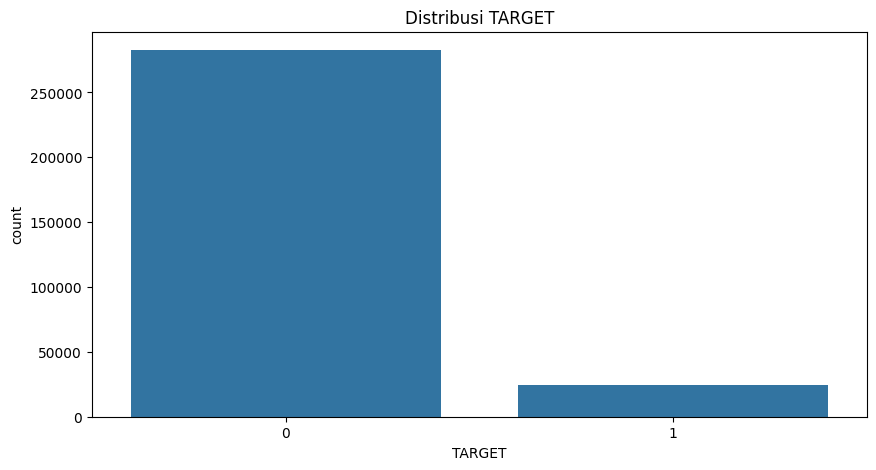

In [7]:
# Memeriksa target variable
print("\nDistribusi TARGET:")
print(train_df['TARGET'].value_counts())
print(f"Persentase nasabah yang gagal bayar: {train_df['TARGET'].mean() * 100:.2f}%")

# Visualisasi distribusi TARGET
plt.figure(figsize=(10, 5))
plt.title('Distribusi TARGET')
sns.countplot(x='TARGET', data=train_df)
plt.show()


Jumlah missing values per kolom:
                          Missing Values  Percentage
COMMONAREA_AVG                    214865   69.872297
COMMONAREA_MODE                   214865   69.872297
COMMONAREA_MEDI                   214865   69.872297
NONLIVINGAPARTMENTS_MEDI          213514   69.432963
NONLIVINGAPARTMENTS_MODE          213514   69.432963
NONLIVINGAPARTMENTS_AVG           213514   69.432963
FONDKAPREMONT_MODE                210295   68.386172
LIVINGAPARTMENTS_AVG              210199   68.354953
LIVINGAPARTMENTS_MEDI             210199   68.354953
LIVINGAPARTMENTS_MODE             210199   68.354953
FLOORSMIN_MODE                    208642   67.848630
FLOORSMIN_AVG                     208642   67.848630
FLOORSMIN_MEDI                    208642   67.848630
YEARS_BUILD_AVG                   204488   66.497784
YEARS_BUILD_MODE                  204488   66.497784
YEARS_BUILD_MEDI                  204488   66.497784
OWN_CAR_AGE                       202929   65.990810
LANDAREA_MED

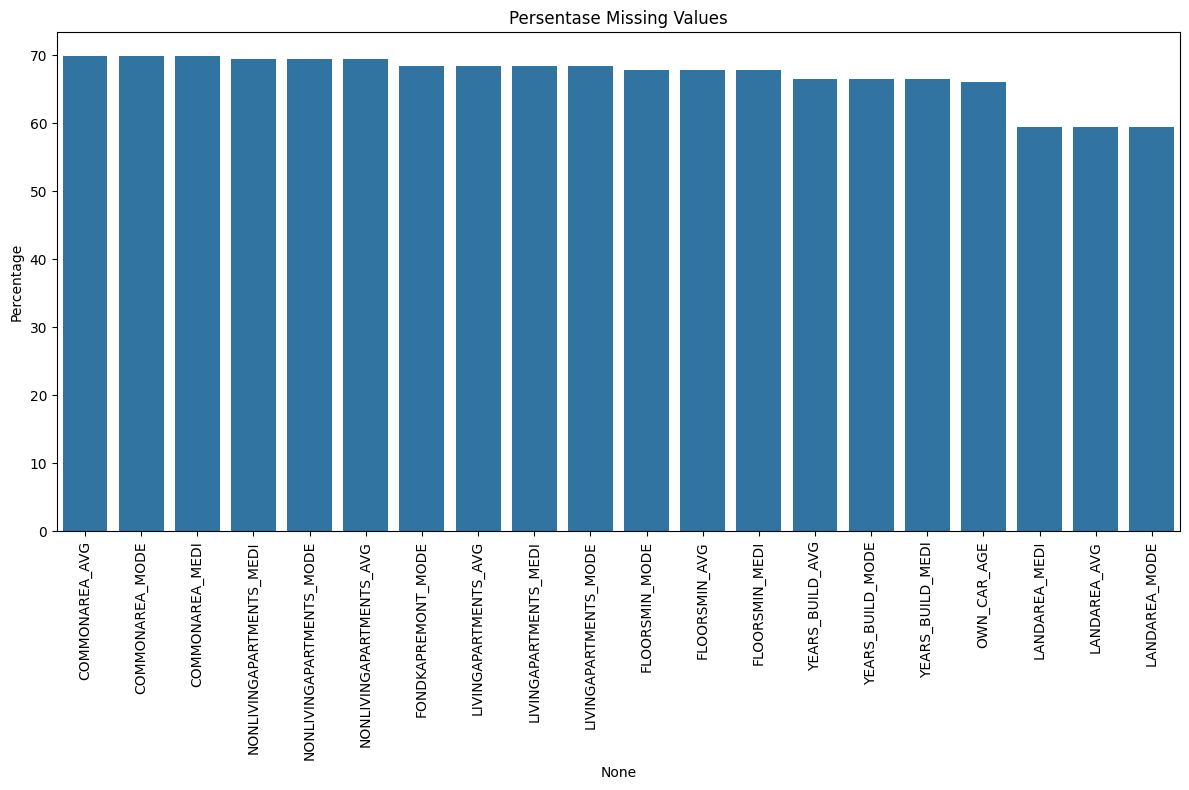

In [8]:
# Mengecek missing values (nilai yang hilang)
print("\nJumlah missing values per kolom:")
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Values'] > 0].head(20))

# Visualisasi missing values
plt.figure(figsize=(12, 8))
plt.title('Persentase Missing Values')
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False).head(20)
sns.barplot(x=missing_df.index, y='Percentage', data=missing_df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Korelasi positif tertinggi dengan TARGET:
TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64

Korelasi negatif tertinggi dengan TARGET:
ELEVATORS_AVG                -0.034199
REGION_POPULATION_RELATIVE   -0.037227
AMT_GOODS_PRICE              -0.039645
FLOORSMAX_MODE               -0.043226
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_AVG                -0.044003
DAYS_EMPLOYED                -0.044932
EXT_SOURCE_1                 -0.155317
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_3                 -0.178919
Name: TARGET, dtype: float64


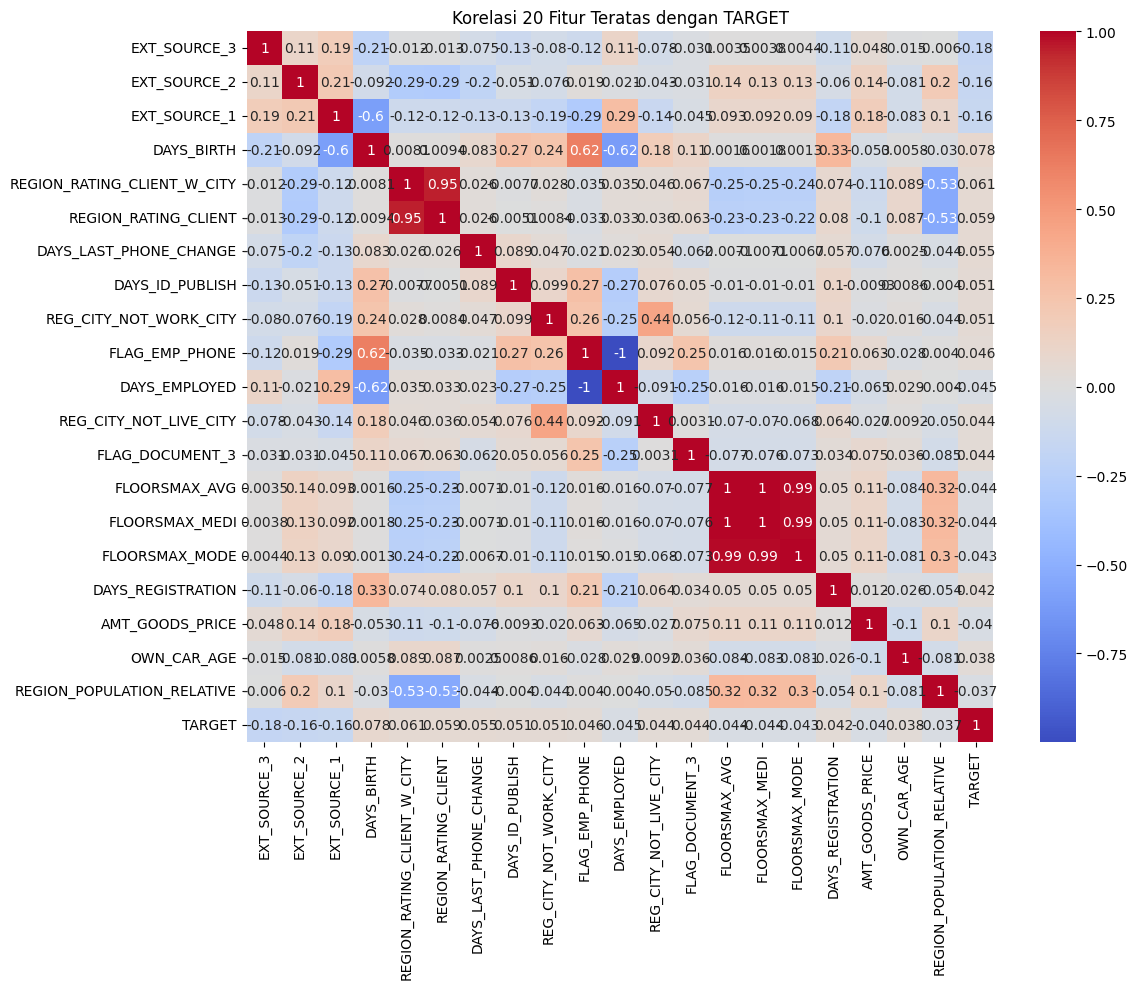

In [9]:
# Memeriksa korelasi antara fitur dan target
numeric_features = train_df.select_dtypes(include=[np.number])
correlations = numeric_features.corr()['TARGET'].sort_values(ascending=False)

print("\nKorelasi positif tertinggi dengan TARGET:")
print(correlations.head(10))

print("\nKorelasi negatif tertinggi dengan TARGET:")
print(correlations.tail(10))

# Visualisasi korelasi
plt.figure(figsize=(12, 10))
plt.title('Korelasi 20 Fitur Teratas dengan TARGET')
top_features = correlations.abs().sort_values(ascending=False).head(21).index.tolist()[1:]  # exclude TARGET
sns.heatmap(train_df[top_features + ['TARGET']].corr(), annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()


Jumlah variabel kategorikal: 16
Contoh variabel kategorikal: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE']


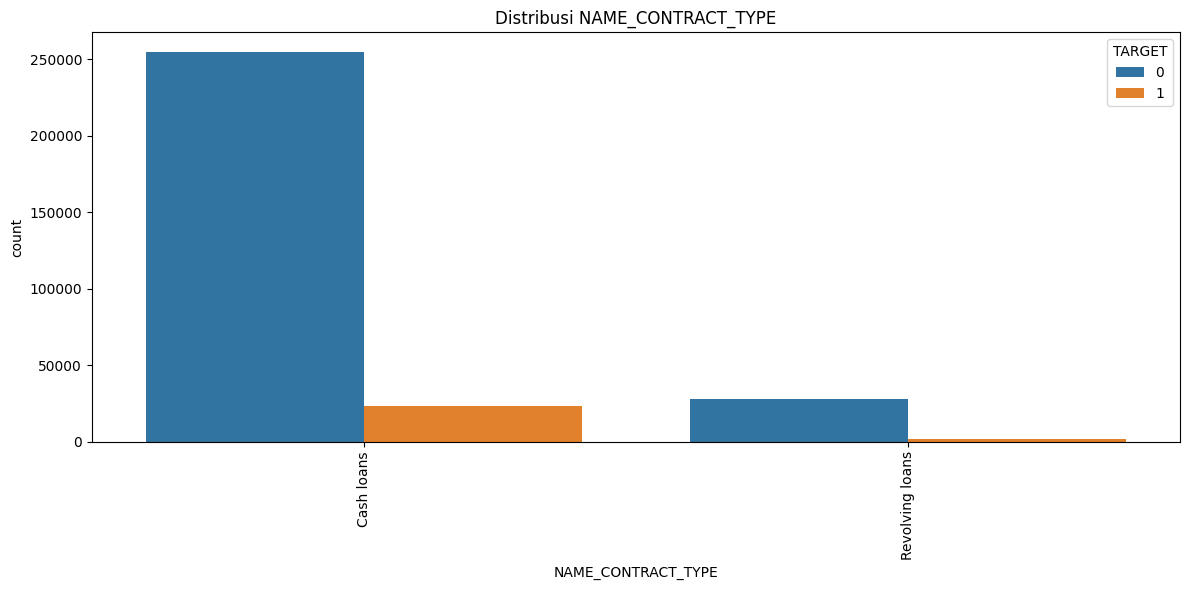


Persentase gagal bayar untuk setiap kategori di NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         0.083459
Revolving loans    0.054783
dtype: float64


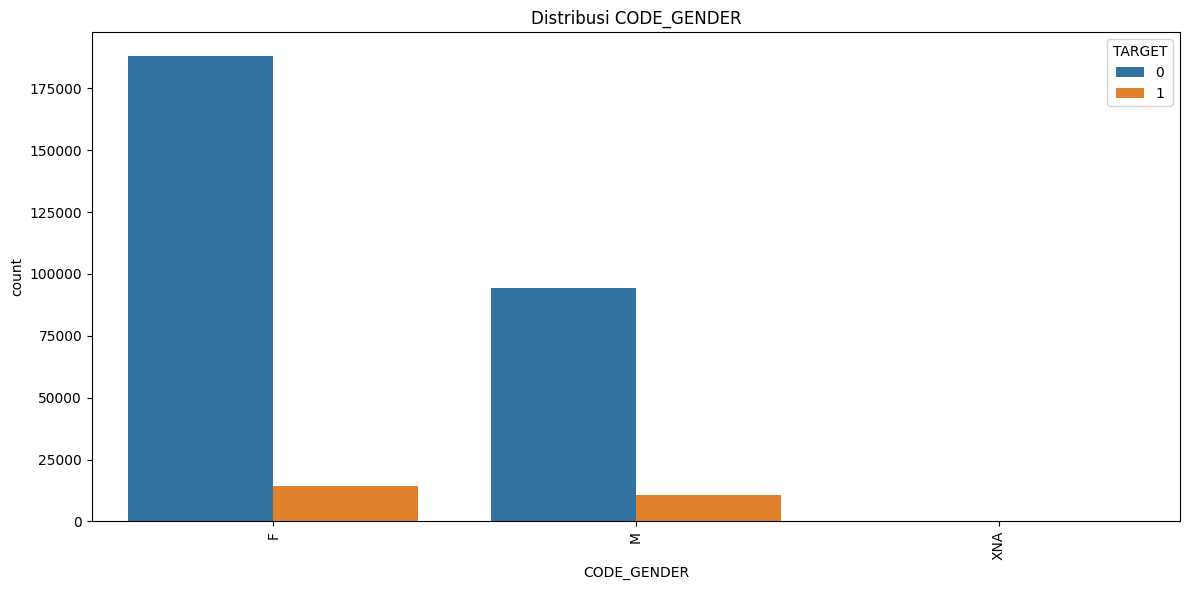


Persentase gagal bayar untuk setiap kategori di CODE_GENDER:
CODE_GENDER
M      0.101419
F      0.069993
XNA         NaN
dtype: float64


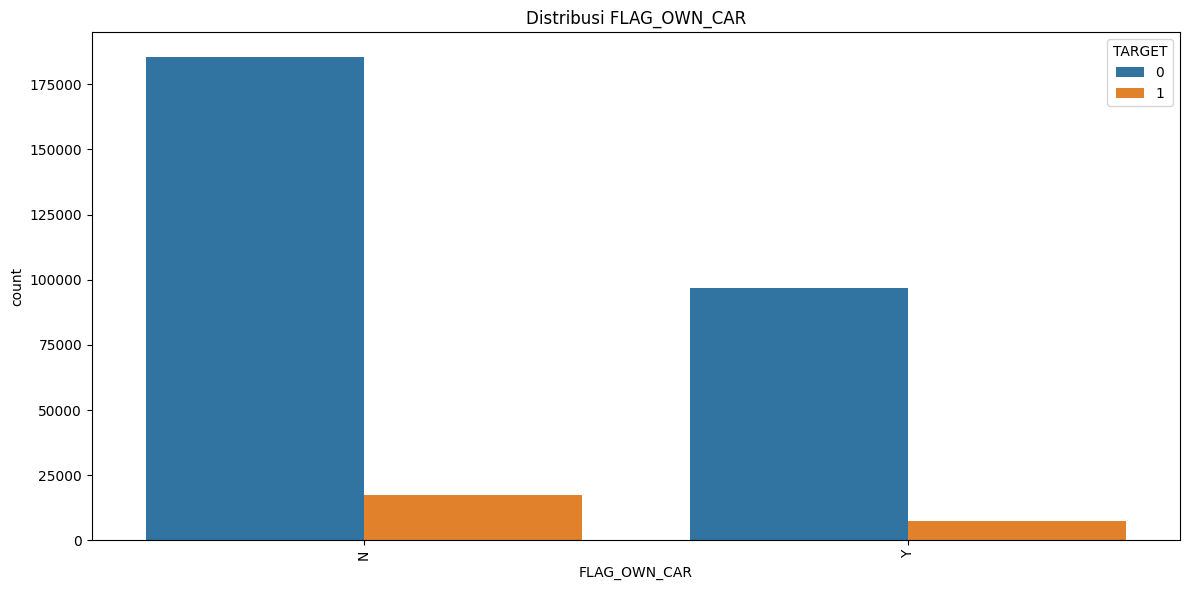


Persentase gagal bayar untuk setiap kategori di FLAG_OWN_CAR:
FLAG_OWN_CAR
N    0.085002
Y    0.072437
dtype: float64


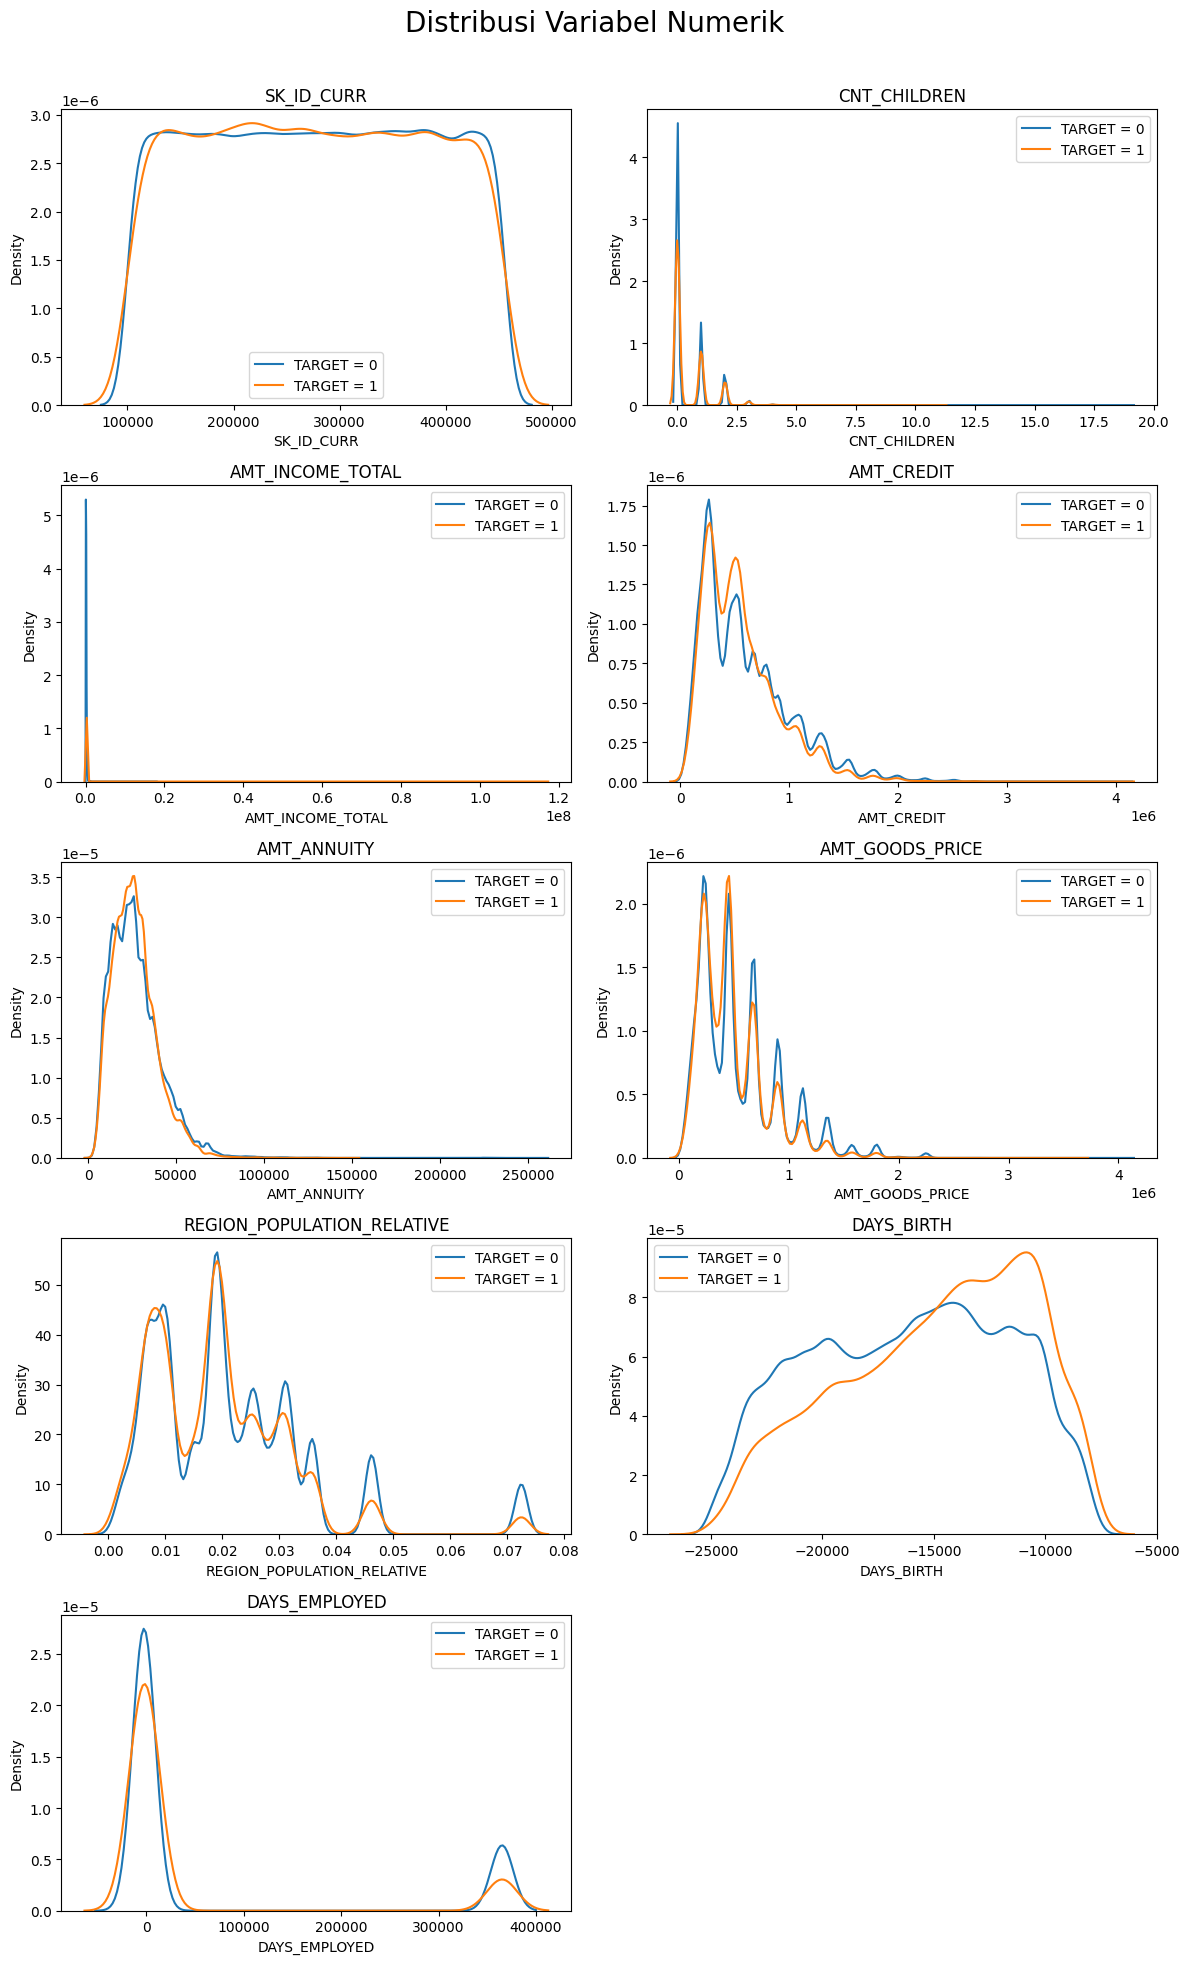

In [10]:
# Menganalisis variabel kategorikal
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"\nJumlah variabel kategorikal: {len(categorical_features)}")
print("Contoh variabel kategorikal:", categorical_features[:5])

# Distribusi beberapa variabel kategorikal
for feature in categorical_features[:3]:  # Hanya 3 fitur pertama untuk contoh
    plt.figure(figsize=(12, 6))
    plt.title(f'Distribusi {feature}')
    sns.countplot(data=train_df, x=feature, hue='TARGET', order=train_df[feature].value_counts().index)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Menampilkan persentase gagal bayar berdasarkan kategori
    counts = train_df.groupby([feature, 'TARGET']).size().unstack()
    percentages = counts[1] / (counts[0] + counts[1])
    print(f"\nPersentase gagal bayar untuk setiap kategori di {feature}:")
    print(percentages.sort_values(ascending=False).head(10))

# Menganalisis distribusi variabel numerik
plt.figure(figsize=(12, 20))
plt.suptitle('Distribusi Variabel Numerik', fontsize=20)
j = 1
for feature in numeric_features.columns[:10]:  # Hanya 10 fitur pertama untuk contoh
    if feature != 'TARGET':
        plt.subplot(5, 2, j)
        plt.title(feature)
        sns.kdeplot(train_df[train_df['TARGET'] == 0][feature], label='TARGET = 0')
        sns.kdeplot(train_df[train_df['TARGET'] == 1][feature], label='TARGET = 1')
        plt.legend()
        j += 1
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## 3. DATA PREPARATION

In [11]:
print("\n====== DATA PREPARATION ======")

# Menggabungkan train dan test untuk preprocessing
test_df['TARGET'] = np.nan
all_data = pd.concat([train_df, test_df], axis=0)

# Menyimpan ID dan TARGET asli
train_ids = train_df['SK_ID_CURR']
test_ids = test_df['SK_ID_CURR']
train_target = train_df['TARGET']

# Hapus kolom ID karena tidak diperlukan untuk pemodelan
all_data = all_data.drop('SK_ID_CURR', axis=1)

# Membersihkan data dari nilai ekstrem dan tidak valid
print("\nMembersihkan data dari nilai ekstrem...")

# Fix untuk nilai Employed Days (jika negatif terlalu besar, mungkin adalah kode untuk pengangguran)
all_data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Penanganan nilai yang hilang (missing values)
print("\nMenangani missing values...")

# Untuk kolom numerik, ganti dengan median
for col in all_data.select_dtypes(include=[np.number]).columns:
    if col != 'TARGET':
        all_data[col] = all_data[col].fillna(all_data[col].median())

# Untuk kolom kategorikal, ganti dengan modus
for col in all_data.select_dtypes(include=['object']).columns:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Encoding variabel kategorikal
print("\nEncoding variabel kategorikal...")
for col in all_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    le.fit(all_data[col])
    all_data[col] = le.transform(all_data[col])

# Feature Engineering
print("\nMelakukan feature engineering...")

# 1. Rasio kredit terhadap pendapatan
all_data['CREDIT_INCOME_RATIO'] = all_data['AMT_CREDIT'] / all_data['AMT_INCOME_TOTAL']

# 2. Rasio angsuruan terhadap pendapatan
all_data['ANNUITY_INCOME_RATIO'] = all_data['AMT_ANNUITY'] / all_data['AMT_INCOME_TOTAL']

# 3. Usia dalam tahun (dari hari)
all_data['DAYS_BIRTH_YEARS'] = abs(all_data['DAYS_BIRTH']) / 365

# 4. Rasio kredit terhadap nilai barang
all_data['CREDIT_GOODS_RATIO'] = all_data['AMT_CREDIT'] / all_data['AMT_GOODS_PRICE']

# 5. Rasio antara days employed dan days birth
all_data['EMPLOYED_TO_BIRTH_RATIO'] = abs(all_data['DAYS_EMPLOYED']) / abs(all_data['DAYS_BIRTH'])

# 6. Apakah melebihi usia pensiun (65 tahun)
all_data['IS_RETIRED'] = (all_data['DAYS_BIRTH_YEARS'] > 65).astype(int)

# 7. Total pendapatan keluarga
all_data['TOTAL_FAMILY_INCOME'] = all_data['AMT_INCOME_TOTAL'] * all_data['CNT_FAM_MEMBERS']
all_data['INCOME_PER_FAMILY_MEMBER'] = all_data['AMT_INCOME_TOTAL'] / all_data['CNT_FAM_MEMBERS']

# Pembagian kembali dataset menjadi train dan test
print("\nMembagi kembali dataset menjadi train dan test...")
train_df = all_data[~all_data['TARGET'].isna()].drop('TARGET', axis=1)
test_df = all_data[all_data['TARGET'].isna()].drop('TARGET', axis=1)

# Standarisasi fitur numerik
print("\nStandarisasi fitur numerik...")
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

# Tambahkan kembali kolom TARGET ke train_df
train_df['TARGET'] = train_target.values

print("\nDataset setelah preprocessing:")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


====== DATA PREPARATION ======

Membersihkan data dari nilai ekstrem...

Menangani missing values...

Encoding variabel kategorikal...

Melakukan feature engineering...

Membagi kembali dataset menjadi train dan test...

Standarisasi fitur numerik...

Dataset setelah preprocessing:
Train shape: (307511, 129)
Test shape: (48744, 128)


## 4. MODELING

In [12]:
print("\n====== MODELING ======")

# Pisahkan fitur dan target
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

# Split data untuk training dan validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Model Evaluation Function
def evaluate_model(name, y_true, y_pred_proba):
    """
    Evaluasi model berdasarkan AUC dan metrik lainnya
    """
    # ROC-AUC
    auc = roc_auc_score(y_true, y_pred_proba)
    
    # Menghitung metrik dengan threshold 0.5
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\nEvaluasi Model {name}:")
    print(f"AUC: {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()
    
    return auc, precision, recall, f1


====== MODELING ======
Training set: (246008, 128)
Validation set: (61503, 128)



Model 1: Logistic Regression

Evaluasi Model Logistic Regression:
AUC: 0.7476
Precision: 0.1602
Recall: 0.6731
F1 Score: 0.2589

Confusion Matrix:
[[39024 17514]
 [ 1623  3342]]


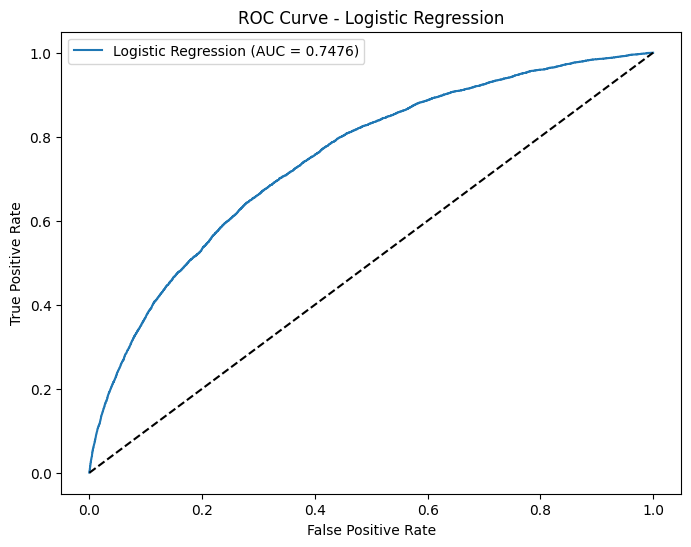

Training Logistic Regression - selesai dalam 6 detik


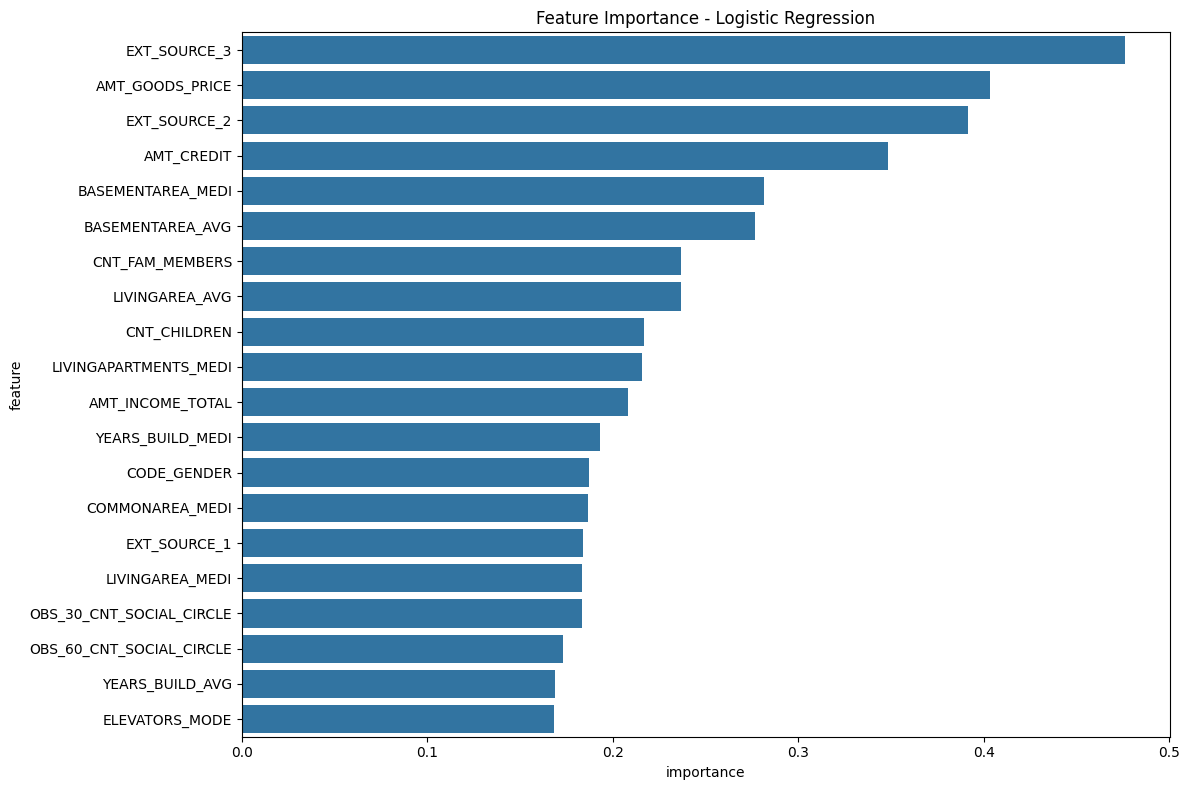

In [13]:
# Model 1: Logistic Regression (wajib)
print("\nModel 1: Logistic Regression")
with timer("Training Logistic Regression"):
    log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)
    
    # Prediksi pada data validasi
    y_pred_proba_lr = log_reg.predict_proba(X_val)[:, 1]
    
    # Evaluasi
    lr_metrics = evaluate_model("Logistic Regression", y_val, y_pred_proba_lr)

# Feature Importance untuk Logistic Regression
importances_lr = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(log_reg.coef_[0])
})
importances_lr = importances_lr.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.title('Feature Importance - Logistic Regression')
sns.barplot(x='importance', y='feature', data=importances_lr.head(20))
plt.tight_layout()
plt.show()


Model 2: Random Forest

Evaluasi Model Random Forest:
AUC: 0.7243
Precision: 0.5500
Recall: 0.0044
F1 Score: 0.0088

Confusion Matrix:
[[56520    18]
 [ 4943    22]]


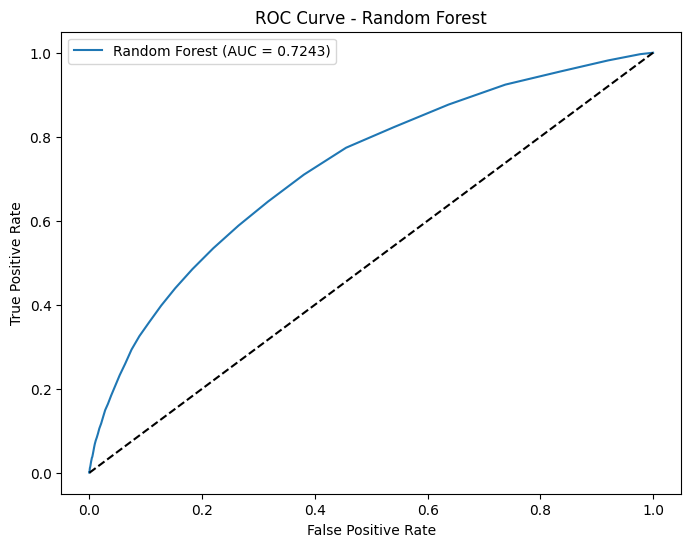

Training Random Forest - selesai dalam 26 detik


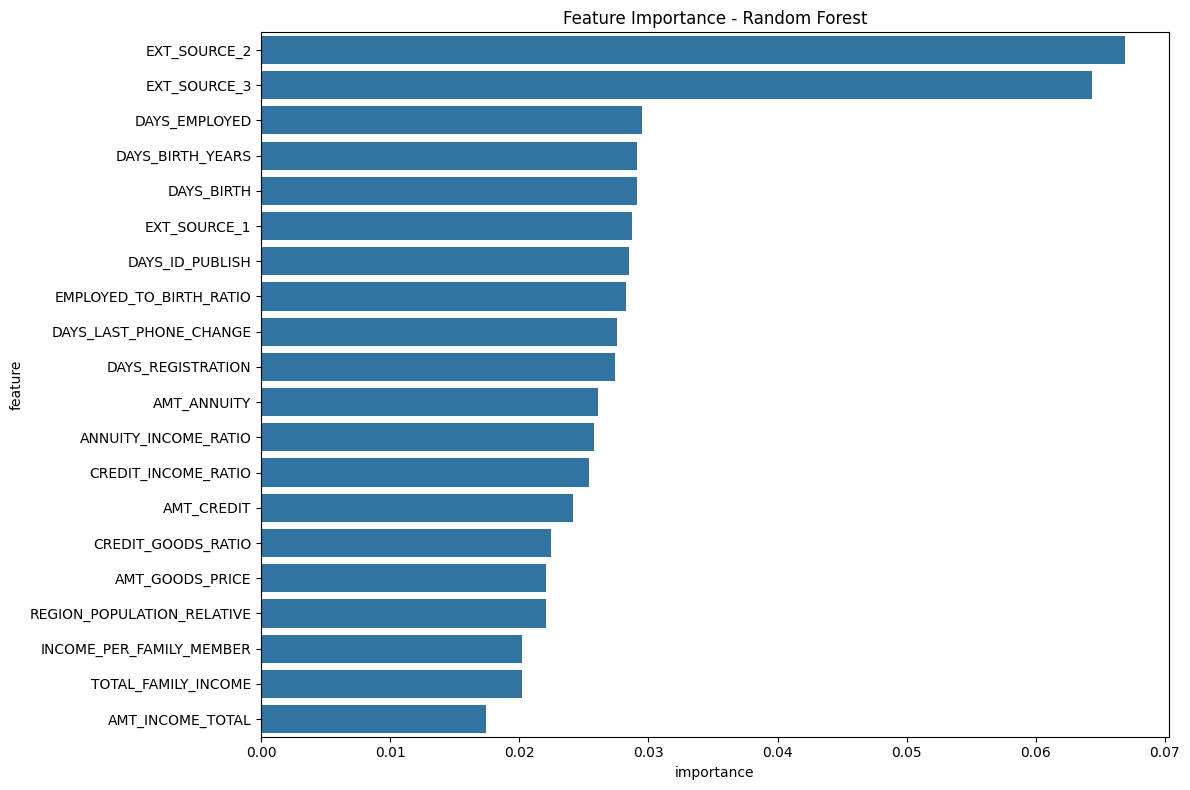

In [14]:
# Model 2: Random Forest
print("\nModel 2: Random Forest")
with timer("Training Random Forest"):
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Prediksi pada data validasi
    y_pred_proba_rf = rf.predict_proba(X_val)[:, 1]
    
    # Evaluasi
    rf_metrics = evaluate_model("Random Forest", y_val, y_pred_proba_rf)

# Feature Importance untuk Random Forest
importances_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})
importances_rf = importances_rf.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.title('Feature Importance - Random Forest')
sns.barplot(x='importance', y='feature', data=importances_rf.head(20))
plt.tight_layout()
plt.show()

In [15]:
# Model 3: LightGBM (optional, untuk perbandingan)
try:
    print("\nModel 3: LightGBM")
    with timer("Training LightGBM"):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
            'is_unbalance': True
        }
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        lgb_model = lgb.train(
            params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=[lgb_train, lgb_val],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        
        # Prediksi pada data validasi
        y_pred_proba_lgb = lgb_model.predict(X_val)
        
        # Evaluasi
        lgb_metrics = evaluate_model("LightGBM", y_val, y_pred_proba_lgb)
        
        # Feature Importance untuk LightGBM
        importances_lgb = pd.DataFrame({
            'feature': X.columns,
            'importance': lgb_model.feature_importance('gain')
        })
        importances_lgb = importances_lgb.sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importance - LightGBM')
        sns.barplot(x='importance', y='feature', data=importances_lgb.head(20))
        plt.tight_layout()
        plt.show()
except:
    print("LightGBM tidak berhasil dijalankan. Lanjut ke tahap berikutnya.")


Model 3: LightGBM
LightGBM tidak berhasil dijalankan. Lanjut ke tahap berikutnya.


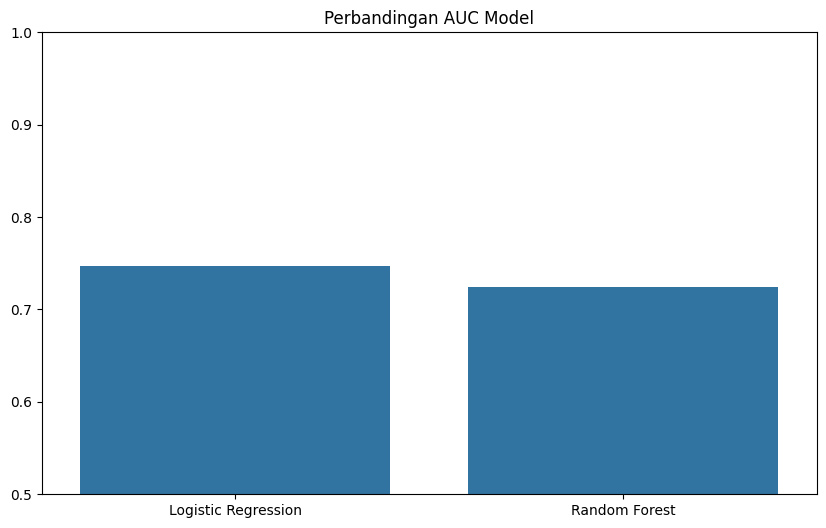


Membuat prediksi pada test set...
Model terbaik: Logistic Regression
File submission telah dibuat: submission.csv


In [16]:
# Perbandingan Model (tanpa LightGBM)
models = ['Logistic Regression', 'Random Forest']
auc_scores = [lr_metrics[0], rf_metrics[0]]  # Misal index 0 adalah AUC

plt.figure(figsize=(10, 6))
plt.title('Perbandingan AUC Model')
sns.barplot(x=models, y=auc_scores)
plt.ylim(0.5, 1.0)
plt.show()

# Prediksi pada test set menggunakan model terbaik
print("\nMembuat prediksi pada test set...")

# Menggunakan model dengan AUC tertinggi untuk prediksi final
best_model_idx = np.argmax(auc_scores)
best_model_name = models[best_model_idx]

if best_model_name == 'Logistic Regression':
    y_test_pred = log_reg.predict_proba(test_df)[:, 1]
else:  # Random Forest
    y_test_pred = rf.predict_proba(test_df)[:, 1]

print(f"Model terbaik: {best_model_name}")

# Membuat submission file
submission = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'TARGET': y_test_pred
})

submission.to_csv('submission.csv', index=False)
print("File submission telah dibuat: submission.csv")


## 5. BUSINESS INSIGHT & RECOMMENDATIONS

In [17]:
print("\n====== BUSINESS INSIGHT & RECOMMENDATIONS ======")

# Mengekstrak insight dari data 
# 1. Faktor yang paling mempengaruhi risiko gagal bayar
if best_model_name == 'Logistic Regression':
    top_features = importances_lr.head(10)
    model = log_reg
elif best_model_name == 'Random Forest':
    top_features = importances_rf.head(10)
    model = rf
else:  # LightGBM
    top_features = importances_lgb.head(10)
    model = lgb_model

print("\nFaktor paling berpengaruh dalam menentukan risiko gagal bayar:")
print(top_features)


====== BUSINESS INSIGHT & RECOMMENDATIONS ======

Faktor paling berpengaruh dalam menentukan risiko gagal bayar:
                  feature  importance
41           EXT_SOURCE_3    0.476457
8         AMT_GOODS_PRICE    0.403608
40           EXT_SOURCE_2    0.391564
6              AMT_CREDIT    0.348564
71      BASEMENTAREA_MEDI    0.281375
43       BASEMENTAREA_AVG    0.276725
27        CNT_FAM_MEMBERS    0.236928
53         LIVINGAREA_AVG    0.236655
4            CNT_CHILDREN    0.216610
80  LIVINGAPARTMENTS_MEDI    0.215875


In [18]:
# 2. Analisis segmen nasabah
print("\nAnalisis segmen nasabah berdasarkan risiko:")

# Reset train_df dengan data asli untuk analisis
train_df_original = pd.read_csv('application_train.csv')

# Menambahkan prediksi probabilitas
if best_model_name == 'Logistic Regression' or best_model_name == 'Random Forest':
    train_df_original['RISK_PROBABILITY'] = model.predict_proba(X)[:, 1]
else:  # LightGBM
    train_df_original['RISK_PROBABILITY'] = lgb_model.predict(X)

# Buat kolom rasio kredit terhadap pendapatan
train_df_original['CREDIT_INCOME_RATIO'] = train_df_original['AMT_CREDIT'] / train_df_original['AMT_INCOME_TOTAL']

# Membuat segmen berdasarkan risiko
train_df_original['RISK_SEGMENT'] = pd.qcut(train_df_original['RISK_PROBABILITY'], 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Analisis karakteristik untuk setiap segmen risiko
risk_segments = train_df_original.groupby('RISK_SEGMENT').agg({
    'TARGET': 'mean',
    'AMT_INCOME_TOTAL': 'median',
    'AMT_CREDIT': 'median',
    'AMT_ANNUITY': 'median',
    'DAYS_BIRTH': lambda x: -x.mean() / 365,
    'DAYS_EMPLOYED': lambda x: -x.mean() / 365,
    'CREDIT_INCOME_RATIO': 'mean'
}).reset_index()

risk_segments.columns = ['RISK_SEGMENT', 'Default Rate', 'Median Income', 'Median Credit Amount', 
                         'Median Annuity', 'Average Age', 'Average Years Employed', 'Credit to Income Ratio']

print(risk_segments)



Analisis segmen nasabah berdasarkan risiko:
  RISK_SEGMENT  Default Rate  Median Income  Median Credit Amount  \
0          Low      0.019251       157500.0              540000.0   
1   Medium-Low      0.041689       151533.0              523597.5   
2  Medium-High      0.077110       135000.0              509400.0   
3         High      0.184864       135000.0              480060.0   

   Median Annuity  Average Age  Average Years Employed  Credit to Income Ratio  
0         25128.0    48.302332             -257.403695                3.921030  
1         24876.0    45.728240             -211.485236                4.021137  
2         24759.0    43.031920             -151.434298                4.008042  
3         24844.5    38.685388              -79.019435                3.880072  



Risiko berdasarkan jenis pekerjaan:
              Occupation  Default Rate  Count
9     Low-skill Laborers      0.171524   2093
4                Drivers      0.113261  18603
17  Waiters/barmen staff      0.112760   1348
16        Security staff      0.107424   6721
8               Laborers      0.105788  55186
2          Cooking staff      0.104440   5946
14           Sales staff      0.096318  32102
1         Cleaning staff      0.096067   4653
13         Realty agents      0.078562    751
15           Secretaries      0.070498   1305


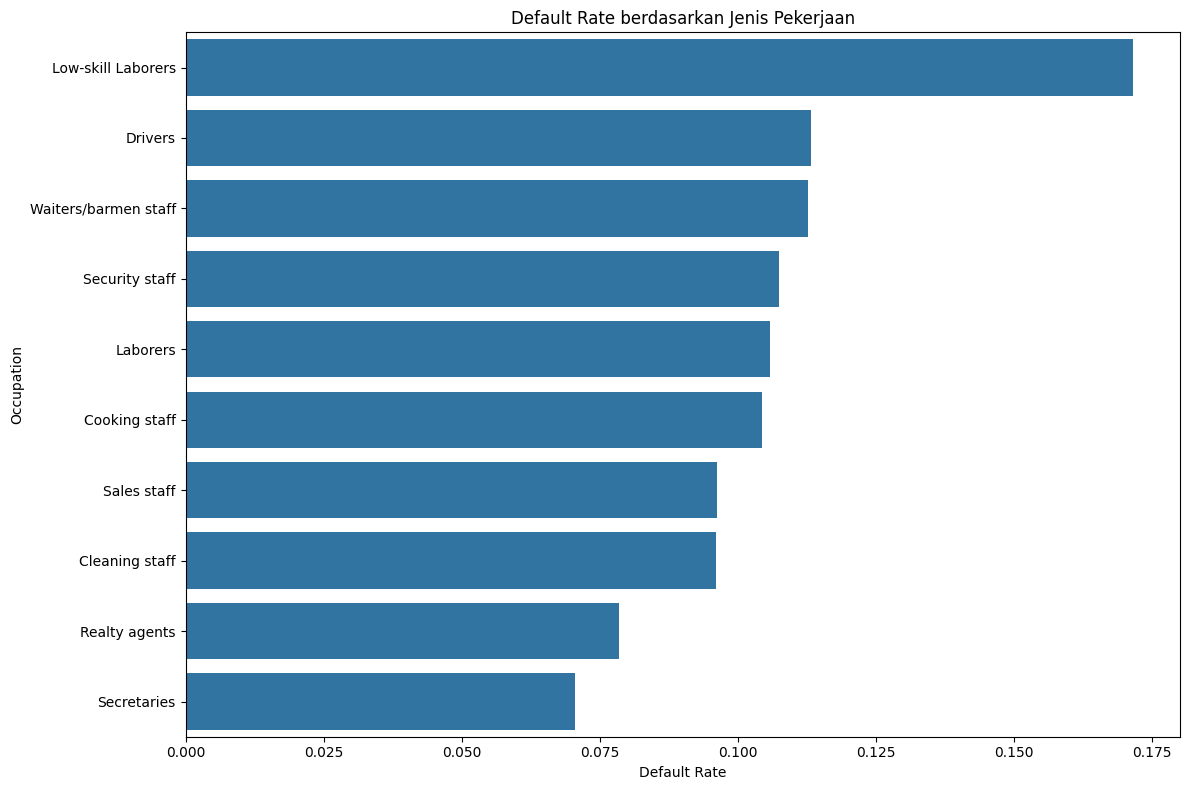

In [19]:
# 3. Analisis kelompok pekerjaan vs. risiko gagal bayar
if 'OCCUPATION_TYPE' in train_df_original.columns:
    occupation_risk = train_df_original.groupby('OCCUPATION_TYPE').agg({
        'TARGET': 'mean',
        'SK_ID_CURR': 'count'
    }).reset_index()
    
    occupation_risk.columns = ['Occupation', 'Default Rate', 'Count']
    occupation_risk = occupation_risk.sort_values('Default Rate', ascending=False)
    
    print("\nRisiko berdasarkan jenis pekerjaan:")
    print(occupation_risk.head(10))
    
    plt.figure(figsize=(12, 8))
    plt.title('Default Rate berdasarkan Jenis Pekerjaan')
    sns.barplot(x='Default Rate', y='Occupation', data=occupation_risk.head(10))
    plt.tight_layout()
    plt.show()


Risiko berdasarkan rentang pendapatan:
              Income Range  Default Rate  Count
0     (25649.999, 99000.0]      0.082062  63671
1      (99000.0, 135000.0]      0.085883  85756
2     (135000.0, 162000.0]      0.086847  35453
3     (162000.0, 225000.0]      0.080569  75513
4  (225000.0, 117000000.0]      0.065198  47118


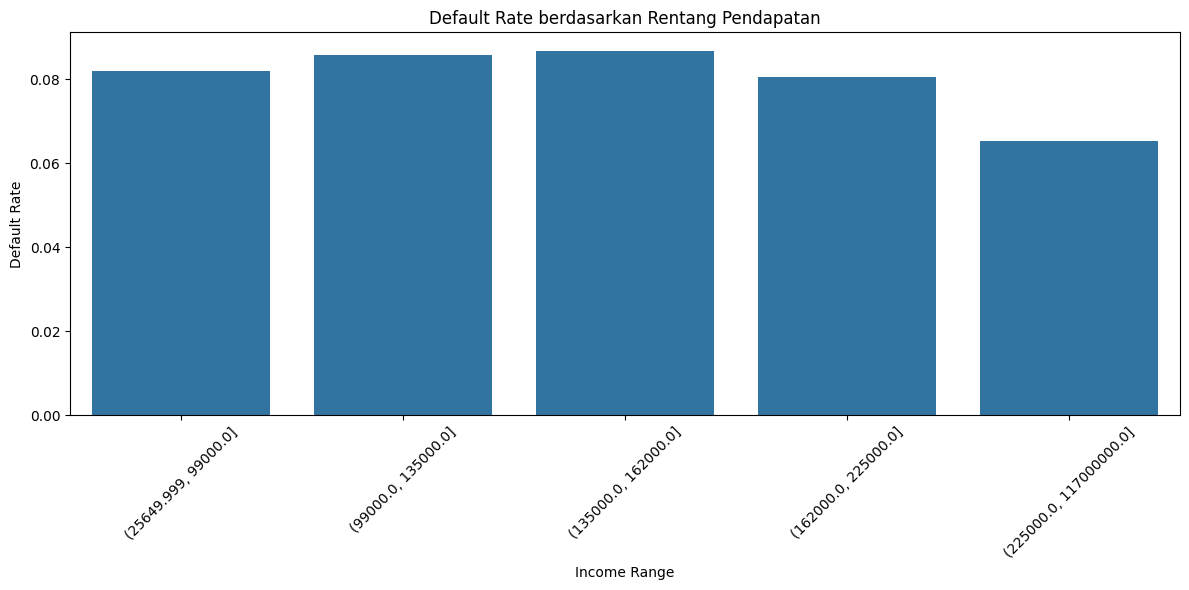

In [20]:
# 4. Analisis pendapatan vs. risiko gagal bayar
income_bins = pd.qcut(train_df_original['AMT_INCOME_TOTAL'], 5)
income_risk = train_df_original.groupby(income_bins).agg({
    'TARGET': 'mean',
    'SK_ID_CURR': 'count'
}).reset_index()

income_risk.columns = ['Income Range', 'Default Rate', 'Count']

print("\nRisiko berdasarkan rentang pendapatan:")
print(income_risk)

plt.figure(figsize=(12, 6))
plt.title('Default Rate berdasarkan Rentang Pendapatan')
sns.barplot(x='Income Range', y='Default Rate', data=income_risk)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Risiko berdasarkan rentang usia:
  Age Range  Default Rate  Count
0     20-30      0.114569  45021
1     30-40      0.095835  82308
2     40-50      0.076508  76541
3     50-60      0.061297  68062
4     60-70      0.049214  35579
5       70+           NaN      0


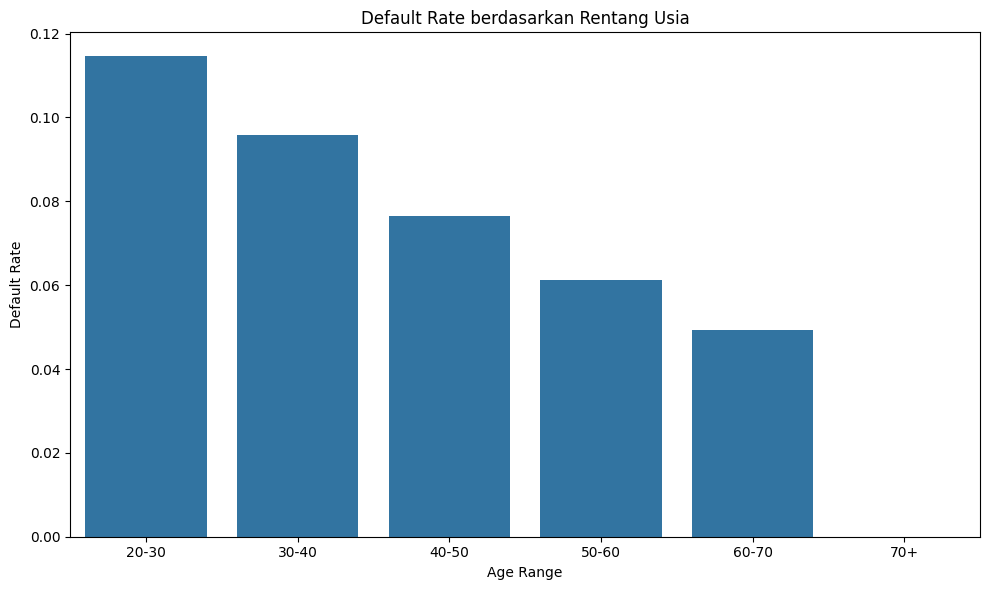

In [21]:
# 5. Analisis usia vs. risiko gagal bayar
train_df_original['AGE_YEARS'] = -train_df_original['DAYS_BIRTH'] / 365
age_bins = pd.cut(train_df_original['AGE_YEARS'], 
                 bins=[20, 30, 40, 50, 60, 70, 100],
                 labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70+'])

age_risk = train_df_original.groupby(age_bins).agg({
    'TARGET': 'mean',
    'SK_ID_CURR': 'count'
}).reset_index()

age_risk.columns = ['Age Range', 'Default Rate', 'Count']

print("\nRisiko berdasarkan rentang usia:")
print(age_risk)

plt.figure(figsize=(10, 6))
plt.title('Default Rate berdasarkan Rentang Usia')
sns.barplot(x='Age Range', y='Default Rate', data=age_risk)
plt.tight_layout()
plt.show()

In [22]:
# 6. Rekomendasi Bisnis
print("\nREKOMENDASI BISNIS:")
print("1. Fokus pada segmen dengan risiko rendah untuk ekspansi portfolio pinjaman")
print("2. Meningkatkan persyaratan atau bunga untuk segmen berisiko tinggi")
print("3. Menyesuaikan produk pinjaman berdasarkan karakteristik demografis")
print("4. Implementasi sistem scoring berdasarkan model prediksi yang dibuat")
print("5. Melakukan verifikasi lebih detail untuk aplikasi dari segmen berisiko tinggi")


REKOMENDASI BISNIS:
1. Fokus pada segmen dengan risiko rendah untuk ekspansi portfolio pinjaman
2. Meningkatkan persyaratan atau bunga untuk segmen berisiko tinggi
3. Menyesuaikan produk pinjaman berdasarkan karakteristik demografis
4. Implementasi sistem scoring berdasarkan model prediksi yang dibuat
5. Melakukan verifikasi lebih detail untuk aplikasi dari segmen berisiko tinggi


## 6. EVALUASI & DEPLOYMENT

In [23]:
print("\n====== EVALUASI & DEPLOYMENT ======")

# Ringkasan model dan performa
print("\nRingkasan model:")
for i, model_name in enumerate(models):
    print(f"{model_name}: AUC = {auc_scores[i]:.4f}")
    
print(f"\nModel terbaik: {best_model_name} dengan AUC = {max(auc_scores):.4f}")

# Langkah-langkah deployment
print("\nLangkah-langkah deployment:")
print("1. Penyimpanan model terbaik untuk digunakan secara produksi")
print("2. Integrasi model dengan sistem aplikasi pinjaman Home Credit")
print("3. Pengembangan dashboard untuk monitoring performa model")
print("4. Pelatihan staf mengenai penggunaan model dan interpretasi hasil")
print("5. Evaluasi berkala dan retraining model dengan data baru")

print("\nAnalisis prediksi kredit Home Credit telah selesai!")


====== EVALUASI & DEPLOYMENT ======

Ringkasan model:
Logistic Regression: AUC = 0.7476
Random Forest: AUC = 0.7243

Model terbaik: Logistic Regression dengan AUC = 0.7476

Langkah-langkah deployment:
1. Penyimpanan model terbaik untuk digunakan secara produksi
2. Integrasi model dengan sistem aplikasi pinjaman Home Credit
3. Pengembangan dashboard untuk monitoring performa model
4. Pelatihan staf mengenai penggunaan model dan interpretasi hasil
5. Evaluasi berkala dan retraining model dengan data baru

Analisis prediksi kredit Home Credit telah selesai!
